In [11]:
"""CPM Pytorch Implementation"""
import torch
import torch.nn as nn

import torch.utils.model_zoo as model_zoo
from torch.nn import init

def make_stages(cfg_dict):
    """Builds CPM stages from a dictionary
    Args:
    cfg_dict: a dictionary
    """
    layers = []
    for i in range(len(cfg_dict) - 1):
        one_ = cfg_dict[i]
        for k, v in one_.items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
    one_ = list(cfg_dict[-1].keys())
    k = one_[0]
    v = cfg_dict[-1][k]
    conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                       kernel_size=v[2], stride=v[3], padding=v[4])
    layers += [conv2d]
    return nn.Sequential(*layers)


def make_vgg19_block(block):
    """Builds a vgg19 block from a dictionary
    Args:
        block: a dictionary
    """
    layers = []
    for i in range(len(block)):
        one_ = block[i]
        for k, v in one_.items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)



def get_model(trunk='vgg19'):
    """Creates the whole CPM model
    Args:
        trunk: string, 'vgg19' or 'mobilenet'
    Returns: Module, the defined model
    """
    blocks = {}
    # block0 is the preprocessing stage
    if trunk == 'vgg19':
        block0 = [{'conv1_1': [3, 64, 3, 1, 1]},
                  {'conv1_2': [64, 64, 3, 1, 1]},
                  {'pool1_stage1': [2, 2, 0]},
                  {'conv2_1': [64, 128, 3, 1, 1]},
                  {'conv2_2': [128, 128, 3, 1, 1]},
                  {'pool2_stage1': [2, 2, 0]},
                  {'conv3_1': [128, 256, 3, 1, 1]},
                  {'conv3_2': [256, 256, 3, 1, 1]},
                  {'conv3_3': [256, 256, 3, 1, 1]},
                  {'conv3_4': [256, 256, 3, 1, 1]},
                  {'pool3_stage1': [2, 2, 0]},
                  {'conv4_1': [256, 512, 3, 1, 1]},
                  {'conv4_2': [512, 512, 3, 1, 1]},
                  {'conv4_3_CPM': [512, 256, 3, 1, 1]},
                  {'conv4_4_CPM': [256, 128, 3, 1, 1]}]

    elif trunk == 'mobilenet':
        block0 = [{'conv_bn': [3, 32, 2]},  # out: 3, 32, 184, 184
                  {'conv_dw1': [32, 64, 1]},  # out: 32, 64, 184, 184
                  {'conv_dw2': [64, 128, 2]},  # out: 64, 128, 92, 92
                  {'conv_dw3': [128, 128, 1]},  # out: 128, 256, 92, 92
                  {'conv_dw4': [128, 256, 2]},  # out: 256, 256, 46, 46
                  {'conv4_3_CPM': [256, 256, 1, 3, 1]},
                  {'conv4_4_CPM': [256, 128, 1, 3, 1]}]

    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 5):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    models = {}

    if trunk == 'vgg19':
        print("Bulding VGG19")
    models['block0'] = make_vgg19_block(block0)


    for k, v in blocks.items():
        models[k] = make_stages(list(v))

    class rtpose_model(nn.Module):
        def __init__(self, model_dict):
            super(rtpose_model, self).__init__()
            self.model0 = model_dict['block0']
            self.model1_1 = model_dict['block1_1']
            self.model2_1 = model_dict['block2_1']
            self.model3_1 = model_dict['block3_1']
            self.model4_1 = model_dict['block4_1']

            self.model1_2 = model_dict['block1_2']
            self.model2_2 = model_dict['block2_2']
            self.model3_2 = model_dict['block3_2']
            self.model4_2 = model_dict['block4_2']

            self._initialize_weights_norm()

        def forward(self, x):

            saved_for_loss = []
            out1 = self.model0(x)

            out1_1 = self.model1_1(out1)
            out1_2 = self.model1_2(out1)
            out2 = torch.cat([out1_1, out1_2, out1], 1)
            saved_for_loss.append(out1_1)
            saved_for_loss.append(out1_2)

            out2_1 = self.model2_1(out2)
            out2_2 = self.model2_2(out2)
            out3 = torch.cat([out2_1, out2_2, out1], 1)
            saved_for_loss.append(out2_1)
            saved_for_loss.append(out2_2)

            out3_1 = self.model3_1(out3)
            out3_2 = self.model3_2(out3)
            out4 = torch.cat([out3_1, out3_2, out1], 1)
            saved_for_loss.append(out3_1)
            saved_for_loss.append(out3_2)

            out4_1 = self.model4_1(out4)
            out4_2 = self.model4_2(out4)
            saved_for_loss.append(out4_1)
            saved_for_loss.append(out4_2)

            return out4_1, out4_2

        def _initialize_weights_norm(self):

            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    init.normal_(m.weight, std=0.01)
                    if m.bias is not None:  # mobilenet conv2d doesn't add bias
                        init.constant_(m.bias, 0.0)

            # last layer of these block don't have Relu
            init.normal_(self.model1_1[6].weight, std=0.01)
            init.normal_(self.model1_2[6].weight, std=0.01)

            init.normal_(self.model2_1[8].weight, std=0.01)
            init.normal_(self.model3_1[8].weight, std=0.01)
            init.normal_(self.model4_1[8].weight, std=0.01)

            init.normal_(self.model2_2[8].weight, std=0.01)
            init.normal_(self.model3_2[8].weight, std=0.01)
            init.normal_(self.model4_2[8].weight, std=0.01)

    model = rtpose_model(models)
    return model




In [12]:
model = get_model(trunk='vgg19')
model_path = '/content/half_pose.pth'
model = torch.nn.DataParallel(model)
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
model.float()

Bulding VGG19


DataParallel(
  (module): rtpose_model(
    (model0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [19]:
import math
import cv2
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import sys  
sys.path.append(r'/content/')
import time
import config
import connections
import coordinates
import estimators
import util
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

allTime = []
trainTime = []
for i in range(1,2):
    begin = time.time()
    test_img = "%d.jpg" % i # Image path here
    oriImg = cv2.imread("/content/"+test_img) # B,G,R order

    inp_size = 368  
    stride = 8 
    padValue = 128
    thre1 = 0.1
    thre2 = 0.05
    scale_factors = [0.5, 1, 1.5, 2]

    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
    paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
    multipliers = [x * inp_size / oriImg.shape[0] for x in scale_factors]  # 不同尺度下的放缩系数

    for m, scale in enumerate(multipliers):
        imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        imageToTest_padded, pad = util.pad_right_down_corner(imageToTest, stride, padValue)

        im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5


        data = torch.from_numpy(im).float()
        if torch.cuda.is_available():
            data = data.cuda()
        with torch.no_grad():
            Mconv7_stage6_L1, Mconv7_stage6_L2 = model(data)
        Mconv7_stage6_L1 = Mconv7_stage6_L1.cpu().numpy()
        Mconv7_stage6_L2 = Mconv7_stage6_L2.cpu().numpy()

        print("Output shape (heatmap): " + str(Mconv7_stage6_L2.shape))
        print("Output shape (paf): " + str(Mconv7_stage6_L1.shape))


        # extract outputs, resize, and remove padding
        # output 1 is heatmaps
        heatmap = np.transpose(np.squeeze(Mconv7_stage6_L2), (1, 2, 0))
        heatmap = cv2.resize(heatmap, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
        heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]  # 去除填充
        heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        # output 0 is PAFs
        paf = np.transpose(np.squeeze(Mconv7_stage6_L1), (1, 2, 0))
        paf = cv2.resize(paf, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
        paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
        paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        heatmap_avg = heatmap_avg + heatmap / len(multipliers)
        paf_avg = paf_avg + paf / len(multipliers)
    train_end = time.time()
    trainTime.append(train_end-begin)
    
    
    thre1 = 0.1
    thre2 = 0.05


    cfg = config.get_default_configuration()
    coords = coordinates.get_coordinates(cfg, heatmap_avg, thre1)
    conns = connections.get_connections(cfg, coords, paf_avg, thre2)
    skeletons = estimators.estimate(cfg, conns)

    print('coordinates: ')
    print(len(coords),coords["left_eye"])
    print('connections: ')
    print(len(conns))
    print('skeletons: ')
    print(skeletons)

    canvas,white,cur_white = util.draw(cfg, oriImg, coords, skeletons)
    cv2.imwrite("%d_canvas.png" % i, canvas)
    end = time.time()
    allTime.append(end-begin)

with open("testTime.txt", "w") as f:
    print("allTime:",allTime, file = f)
    print("trainTime:",trainTime, file = f)

Output shape (heatmap): (1, 19, 23, 16)
Output shape (paf): (1, 38, 23, 16)
Output shape (heatmap): (1, 19, 46, 31)
Output shape (paf): (1, 38, 46, 31)
Output shape (heatmap): (1, 19, 69, 46)
Output shape (paf): (1, 38, 69, 46)
Output shape (heatmap): (1, 19, 92, 62)
Output shape (paf): (1, 38, 92, 62)
coordinates: 
18 [(138, 116, 0.8092628121376038, 18)]
connections: 
38
skeletons: 
[[ 0.          1.          2.          3.          4.          6.
   7.         10.         11.         13.         14.         15.
  16.         17.         -1.         18.         -1.         19.
  23.00033731 21.        ]]


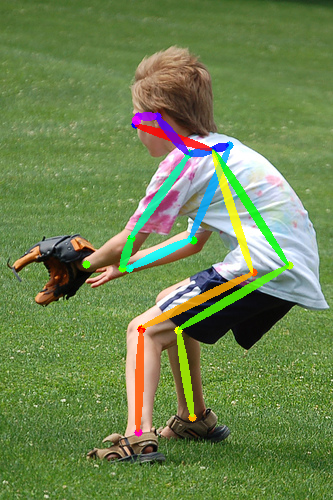

In [20]:
from IPython.display import Image
Image(filename='1_canvas.png') 